# WER Computation for Deepgram and Voci
***
## Part 1:  Parsing
- Parse and normalize **manual transcription** from __*Deepgram*__  
- Parse and normalize **ASR transcription** from __*Deepgram*__
- Parse and normalize **ASR transcription** from __*Voci*__    


### Parsing


#### Imports

In [1]:
import copy
import json
import os
import re

import inflect

#### Instantiate inflect as inflector, this will be used later to convert numbers to words

In [2]:
inflector = inflect.engine()

#### Regex pattern and replace function

In [3]:
re_punc = re.compile(
    (
        r"(?P<vocispeaker>^(AGENT:|CLIENT:))?"
        r"(?P<dgspeaker>^\[[A-Za-z\s\d:]+\])?"
        r"(?P<punctuations>[.,?!-])*"
        r"(?P<ok>okay)?"
        r"(?P<dgunsure>\[unsure:\])?"
        r"(?P<eol>\n$)?"
        r"(?P<multi_space>\s{2,})?"
    ), re.IGNORECASE
)

re_digits = re.compile((r"(?P<digits>(\d+(th|nd|rd)|\d+))*"
                        r"(?P<money>(\$\d*))?"
                        r""), re.MULTILINE)

def ripl(mat=None, li=[]):
    if mat.group("ok"):
        return "ok"
    elif mat.group("eol"):
        return " "
    else:
        return ""

def digit_ripl(mat=None, li=[]):
    if not mat:
        return
    if mat.group("money"):
        money = mat.group("money")[1:]
        return inflector.number_to_words(money) + " dollars "
    elif mat.group("digits"):
        return " " + inflector.number_to_words(mat.group("digits")) + " "
    else:
        return mat.group()

#### Text normalization

In [4]:
def _convert_line_with_digits_to_words(line:str) -> str:
    return re_digits.sub(digit_ripl, line)

def _cleanup(line:str) -> str:
    return re_punc.sub(ripl, line).lower()

def _split_string_to_words(line: str) -> list:
    return list(filter(None, line.split(" ")))

#### Load files from txt and json

- voci_asr will be read from individual text files under /data/voci-asr/*.txt
- deepgram_asr will be read from a json result file under /data/deepgram-asr/results.json
- deepgram_manual will be read from individual text files /data/deepgram-manual/*.txt

In [5]:
def _load_text_file_as_dict_of_transcripts(dir:str, file_name:str):
    file_transcription_dict = dict()
    with open(f"{dir}/{file_name}", "r") as f:
        key = file_name[:-4]
        file_transcription_dict[key] = []
        for line in f:
            clean_line = _cleanup(line)
            try:
                line_no_num = _convert_line_with_digits_to_words(clean_line)
            except Exception as e:
                print(e)
                line_no_num = clean_line
            words = _split_string_to_words(line_no_num)
            file_transcription_dict[key] += words
    return file_transcription_dict

def _load_deepgram_result_json(file_name: str):
    with open(file_name, "r") as f:
        preprocess_result = json.load(f)
    result = dict()
    for file, vals in preprocess_result.get("asr_results").items():
        line = vals.get("asr_words", [])
        clean_line = _cleanup(" ".join(line))
        words = _split_string_to_words(clean_line)
        result.update({file: words})
    return result


In [6]:
def parse(provider: str):

    if "data" not in os.listdir():
        print("Returned nothing")
        return

    result = dict()
    base_dir = ""
    try:
        if provider == "deepgram_manual":
            base_dir = "data/deepgram-manual/"
            filenames = list(os.listdir(base_dir))
            for filename in filenames:
                if not filename.endswith(".txt"):
                    continue
                result.update(_load_text_file_as_dict_of_transcripts(base_dir, filename))
        elif provider == "deepgram_asr":
            base_dir = "data/deepgram-asr/"
            filename = f"{base_dir}/results.json"
            result = _load_deepgram_result_json(filename)
        elif provider == "voci_asr":
            base_dir = "data/voci-asr/"
            filenames = list(os.listdir(base_dir))
            for filename in filenames:
                if not filename.endswith(".txt"):
                    continue
                result.update(_load_text_file_as_dict_of_transcripts(base_dir, filename))
    except FileNotFoundError as e:
        print(e)
        return
    finally:
        with open(f"{base_dir}/output/output.json", "w") as output_file:
            output_file.write(json.dumps(result))
        return result

#### Save parsed data as jupyter variables

In [7]:
dg_manual_parsed = parse("deepgram_manual")

In [8]:
dg_asr_parsed = parse("deepgram_asr")

In [9]:
voci_asr_parsed = parse("voci_asr")

## Part 2: WER Computation

In [10]:
# Copyright 2017-2018 Ben Lambert

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


"""
Primary code for computing word error rate and other metrics from ASR output.
"""
from __future__ import division

from functools import reduce
from collections import defaultdict
from edit_distance import SequenceMatcher

from termcolor import colored


class ComputeWER:
    def __init__(self):

        # Some defaults
        self.print_instances_p = False
        self.print_errors_p = False
        self.confusions = True
        self.min_count = 0
        self.wer_vs_length_p = True

        # For keeping track of the total number of tokens, errors, and matches
        self.ref_token_count = 0
        self.error_count = 0
        self.match_count = 0
        self.counter = 0
        self.sent_error_count = 0

        # For keeping track of word error rates by sentence length
        # this is so we can see if performance is better/worse for longer
        # and/or shorter sentences
        self.lengths = []
        self.error_rates = []
        self.wer_bins = defaultdict(list)
        self.wer_per_file = []
        self.wer_vs_length = defaultdict(list)
        
        # Tables for keeping track of which words get confused with one another
        self.insertion_table = defaultdict(int)
        self.deletion_table = defaultdict(int)
        self.substitution_table = defaultdict(int)
        
        # These are the editdistance opcodes that are condsidered 'errors'
        self.error_codes = ['replace', 'delete', 'insert']


    # TODO - rename this function.  Move some of it into evaluate.py?
    def main(self, ref, hyp):
        """Main method - this reads the hyp and ref files, and creates
        editdistance.SequenceMatcher objects to compute the edit distance.
        All the statistics necessary statistics are collected, and results are
        printed as specified by the command line options.

        This function doesn't not check to ensure that the reference and
        hypothesis file have the same number of lines.  It will stop after the
        shortest one runs out of lines.  This should be easy to fix...
        """
        self.counter = 0
        # Loop through each line of the reference and hyp file
        for ref_line, hyp_line in zip(ref, hyp):
            processed_p = self.process_line_pair(ref_line, hyp_line)
            if processed_p:
                self.counter += 1
        
        # if self.confusions:
        #     self.print_confusions()
        if self.wer_vs_length_p:
            self.print_wer_vs_length()
        
        # Compute WER and WRR
        if self.ref_token_count > 0:
            wrr = self.match_count / self.ref_token_count
            wer = self.error_count / self.ref_token_count
        else:
            wrr = 0.0
            wer = 0.0
        # Compute SER
        ser = self.sent_error_count / self.counter if self.counter > 0 else 0.0
        print('Sentence count: {}'.format(self.counter))
        print('WER: {:10.3%} ({:10d} / {:10d})'.format(wer, self.error_count, self.ref_token_count))
        print('WRR: {:10.3%} ({:10d} / {:10d})'.format(wrr, self.match_count, self.ref_token_count))
        print('SER: {:10.3%} ({:10d} / {:10d})'.format(ser, self.sent_error_count, self.counter))


    def process_line_pair(self, ref_line, hyp_line, case_insensitive=False, remove_empty_refs=False):
        """Given a pair of strings corresponding to a reference and hypothesis,
        compute the edit distance, print if desired, and keep track of results
        in global variables.

        Return true if the pair was counted, false if the pair was not counted due
        to an empty reference string."""

        # Split into tokens by whitespace
        ref = ref_line.split()
        hyp = hyp_line.split()
        id_ = None

        if case_insensitive:
            ref = list(map(str.lower, ref))
            hyp = list(map(str.lower, hyp))
        if remove_empty_refs and len(ref) == 0:
            return False

        # Create an object to get the edit distance, and then retrieve the
        # relevant counts that we need.
        sm = SequenceMatcher(a=ref, b=hyp)
        errors = self.get_error_count(sm)
        matches = self.get_match_count(sm)
        ref_length = len(ref)

        # Increment the total counts we're tracking
        self.error_count += errors
        self.match_count += matches
        self.ref_token_count += ref_length

        if errors != 0:
            self.sent_error_count += 1

        # If we're keeping track of which words get mixed up with which others, call track_confusions
        if self.confusions:
            self.track_confusions(sm, ref, hyp)

        # If we're printing instances, do it here (in roughly the align.c format)
        if self.print_instances_p or (self.print_errors_p and errors != 0):
            self.print_instances(ref, hyp, sm, id_=id_)

        # Keep track of the individual error rates, and reference lengths, so we
        # can compute average WERs by sentence length
        self.lengths.append(ref_length)
        error_rate = errors * 1.0 / len(ref) if len(ref) > 0 else float("inf")
        self.error_rates.append(error_rate)
        self.wer_bins[len(ref)].append(error_rate)

        # Append counts for each line processed
        self.wer_per_file.append({
            'error_count': errors,
            'match_count': matches,
            'ref_token_count': ref_length,
            'wer': error_rate
        })

        return True


    def print_instances(self, ref, hyp, sm, id_=None):
        """Print a single instance of a ref/hyp pair."""
        self.print_diff(sm, ref, hyp)
        if id_:
            print(('SENTENCE {0:d}  {1!s}'.format(self.counter + 1, id_)))
        else:
            print('SENTENCE {0:d}'.format(self.counter + 1))
        # Handle cases where the reference is empty without dying
        if len(ref) != 0:
            correct_rate = sm.matches() / len(ref)
            error_rate = sm.distance() / len(ref)
        elif sm.matches() == 0:
            correct_rate = 1.0
            error_rate = 0.0
        else:
            correct_rate = 0.0
            error_rate = sm.matches()
        print('Correct          = {0:6.1%}  {1:3d}   ({2:6d})'.format(correct_rate, sm.matches(), len(ref)))
        print('Errors           = {0:6.1%}  {1:3d}   ({2:6d})'.format(error_rate, sm.distance(), len(ref)))

    def track_confusions(self, sm, seq1, seq2):
        """Keep track of the errors in a global variable, given a sequence matcher."""
        opcodes = sm.get_opcodes()
        for tag, i1, i2, j1, j2 in opcodes:
            if tag == 'insert':
                for i in range(j1, j2):
                    word = seq2[i]
                    self.insertion_table[word] += 1
            elif tag == 'delete':
                for i in range(i1, i2):
                    word = seq1[i]
                    self.deletion_table[word] += 1
            elif tag == 'replace':
                for w1 in seq1[i1:i2]:
                    for w2 in seq2[j1:j2]:
                        key = (w1, w2)
                        self.substitution_table[key] += 1

    def print_confusions(self):
        """Print the confused words that we found... grouped by insertions, deletions
        and substitutions."""
        if len(self.insertion_table) > 0:
            print('INSERTIONS:')
            for item in sorted(list(self.insertion_table.items()), key=lambda x: x[1], reverse=True):
                if item[1] >= self.min_count:
                    print('{0:20s} {1:10d}'.format(*item))
        if len(self.deletion_table) > 0:
            print('DELETIONS:')
            for item in sorted(list(self.deletion_table.items()), key=lambda x: x[1], reverse=True):
                if item[1] >= self.min_count:
                    print('{0:20s} {1:10d}'.format(*item))
        if len(self.substitution_table) > 0:
            print('SUBSTITUTIONS:')
            for [w1, w2], count in sorted(list(self.substitution_table.items()), key=lambda x: x[1], reverse=True):
                if count >= self.min_count:
                    print('{0:20s} -> {1:20s}   {2:10d}'.format(w1, w2, count))

    # TODO - For some reason I was getting two different counts depending on how I count the matches,
    # so do an assertion in this code to make sure we're getting matching counts.
    # This might slow things down.
    def get_match_count(self, sm):
        "Return the number of matches, given a sequence matcher object."
        matches = None
        matches1 = sm.matches()
        matching_blocks = sm.get_matching_blocks()
        matches2 = reduce(lambda x, y: x + y, [x[2] for x in matching_blocks], 0)
        assert matches1 == matches2
        matches = matches1
        return matches


    def get_error_count(self, sm):
        """Return the number of errors (insertion, deletion, and substitutiions
        , given a sequence matcher object."""
        opcodes = sm.get_opcodes()
        errors = [x for x in opcodes if x[0] in self.error_codes]
        error_lengths = [max(x[2] - x[1], x[4] - x[3]) for x in errors]
        return reduce(lambda x, y: x + y, error_lengths, 0)

    # TODO - This is long and ugly.  Perhaps we can break it up?
    # It would make more sense for this to just return the two strings...
    def print_diff(self, sm, seq1, seq2, prefix1='REF:', prefix2='HYP:', suffix1=None, suffix2=None):
        """Given a sequence matcher and the two sequences, print a Sphinx-style
        'diff' off the two."""
        ref_tokens = []
        hyp_tokens = []
        opcodes = sm.get_opcodes()
        for tag, i1, i2, j1, j2 in opcodes:
            # If they are equal, do nothing except lowercase them
            if tag == 'equal':
                for i in range(i1, i2):
                    ref_tokens.append(seq1[i].lower())
                for i in range(j1, j2):
                    hyp_tokens.append(seq2[i].lower())
            # For insertions and deletions, put a filler of '***' on the other one, and
            # make the other all caps
            elif tag == 'delete':
                for i in range(i1, i2):
                    ref_token = colored(seq1[i].upper(), 'red')
                    ref_tokens.append(ref_token)
                for i in range(i1, i2):
                    hyp_token = colored('*' * len(seq1[i]), 'red')
                    hyp_tokens.append(hyp_token)
            elif tag == 'insert':
                for i in range(j1, j2):
                    ref_token = colored('*' * len(seq2[i]), 'red')
                    ref_tokens.append(ref_token)
                for i in range(j1, j2):
                    hyp_token = colored(seq2[i].upper(), 'red')
                    hyp_tokens.append(hyp_token)
            # More complicated logic for a substitution
            elif tag == 'replace':
                seq1_len = i2 - i1
                seq2_len = j2 - j1
                # Get a list of tokens for each
                s1 = list(map(str.upper, seq1[i1:i2]))
                s2 = list(map(str.upper, seq2[j1:j2]))
                # Pad the two lists with False values to get them to the same length
                if seq1_len > seq2_len:
                    for i in range(0, seq1_len - seq2_len):
                        s2.append(False)
                if seq1_len < seq2_len:
                    for i in range(0, seq2_len - seq1_len):
                        s1.append(False)
                assert len(s1) == len(s2)
                # Pair up words with their substitutions, or fillers
                for i in range(0, len(s1)):
                    w1 = s1[i]
                    w2 = s2[i]
                    # If we have two words, make them the same length
                    if w1 and w2:
                        if len(w1) > len(w2):
                            s2[i] = w2 + ' ' * (len(w1) - len(w2))
                        elif len(w1) < len(w2):
                            s1[i] = w1 + ' ' * (len(w2) - len(w1))
                    # Otherwise, create an empty filler word of the right width
                    if not w1:
                        s1[i] = '*' * len(w2)
                    if not w2:
                        s2[i] = '*' * len(w1)
                s1 = map(lambda x: colored(x, 'red'), s1)
                s2 = map(lambda x: colored(x, 'red'), s2)
                ref_tokens += s1
                hyp_tokens += s2
        if prefix1: ref_tokens.insert(0, prefix1)
        if prefix2: hyp_tokens.insert(0, prefix2)
        if suffix1: ref_tokens.append(suffix1)
        if suffix2: hyp_tokens.append(suffix2)
        print(' '.join(ref_tokens))
        print(' '.join(hyp_tokens))

    def mean(self, seq):
        """Return the average of the elements of a sequence."""
        return float(sum(seq)) / len(seq) if len(seq) > 0 else float('nan')

    def print_wer_vs_length(self):
        """Print the average word error rate for each length sentence."""
        avg_wers = {length: self.mean(wers) for length, wers in self.wer_bins.items()}
        for length, avg_wer in sorted(avg_wers.items(), key=lambda x: (x[1], x[0])):
            self.wer_vs_length[length] = avg_wer
        print('')

### DG WER Computation

In [11]:
dg_wer = ComputeWER()
files = list(dg_manual_parsed.keys())
files.remove('151606--489001--9174886969--183957--371549--00001131381659366966--inbound--delivered--327694')
dg_wer.main([' '.join(dg_manual_parsed[f]) for f in files], [' '.join(dg_asr_parsed[f]) for f in files])


Sentence count: 84
WER:    12.585% (      9195 /      73066)
WRR:    89.537% (     65421 /      73066)
SER:   100.000% (        84 /         84)


[(199, 0.02512562814070352), (524, 0.04389312977099236), (782, 0.04603580562659847)]


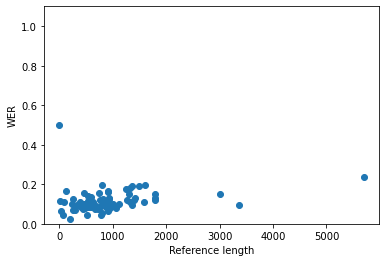

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


plt.scatter(dg_wer.wer_vs_length.keys(), dg_wer.wer_vs_length.values());
plt.xlabel('Reference length')
plt.ylabel('WER')
plt.ylim(0, 1.1)
print(list(dg_wer.wer_vs_length.items())[:3])

In [13]:
pd.DataFrame.from_records(dg_wer.wer_per_file).head()

error_count  match_count  ref_token_count       wer
0         1337         4459             5699  0.234603
1           36          752              782  0.046036
2           44          356              391  0.112532
3           39          416              449  0.086860
4          197         1154             1313  0.150038

In [14]:
pd.DataFrame(dg_wer.deletion_table.items(), columns=['word', 'deletions']).sort_values('deletions', ascending=False).head()

word  deletions
46    i         83
37   to         80
32  the         71
29  you         50
82  and         44

In [15]:
pd.DataFrame(dg_wer.insertion_table.items(), columns=['word', 'insertions']).sort_values('insertions', ascending=False).head()

word  insertions
23     i          65
108   no          64
6    the          59
35     a          53
67     g          52

In [16]:
pd.DataFrame(dg_wer.substitution_table.items(), columns=['word', 'substitutions']).sort_values('substitutions', ascending=False).head(20)

word  substitutions
43        (spiral, spiro)             55
540         (gmail, mail)             50
39      (spiral, spirell)             49
314           (the, this)             47
455     ('cause, because)             43
557         (byebye, bye)             39
862        (spiral, file)             29
587             (o, zero)             26
910           (card, car)             25
585  (doublecheck, check)             23
884       (spiral, spire)             22
156              (a, the)             22
344              (in, on)             19
26             (mkay, ok)             18
159              (the, a)             14
553     (spiral, sparrow)             14
45              (so, sir)             14
298     (spiral, payroll)             13
16              (in, and)             13
392             (to, the)             13

### Voci WER Computation

In [17]:
voci_wer = ComputeWER()
voci_wer.main([' '.join(dg_manual_parsed[f]) for f in files], [' '.join(voci_asr_parsed[f]) for f in files])


Sentence count: 84
WER:    26.195% (     19140 /      73066)
WRR:    76.940% (     56217 /      73066)
SER:   100.000% (        84 /         84)


[(440, 0.11136363636363636), (782, 0.12148337595907928), (524, 0.12404580152671756)]


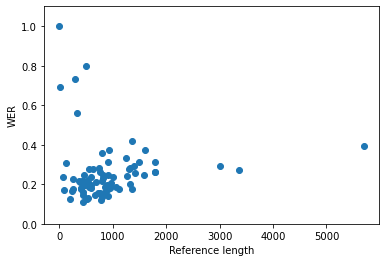

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(voci_wer.wer_vs_length.keys(), voci_wer.wer_vs_length.values());
plt.xlabel('Reference length')
plt.ylabel('WER')
plt.ylim(0, 1.1)
print(list(voci_wer.wer_vs_length.items())[:3])

In [19]:
pd.DataFrame.from_records(voci_wer.wer_per_file).head()

error_count  match_count  ref_token_count       wer
0         2248         3520             5699  0.394455
1           95          702              782  0.121483
2           82          317              391  0.209719
3           66          392              449  0.146993
4          361          990             1313  0.274943

In [20]:
pd.DataFrame(voci_wer.deletion_table.items(), columns=['word', 'deletions']).sort_values('deletions', ascending=False).head()

word  deletions
8     i        309
2   you        261
0    ok        226
62   to        186
55  the        185

In [21]:
pd.DataFrame(voci_wer.insertion_table.items(), columns=['word', 'insertions']).sort_values('insertions', ascending=False).head()

word  insertions
2   and         135
34  you         121
10  the          86
13   to          79
14    i          78

In [22]:
pd.DataFrame(voci_wer.substitution_table.items(), columns=['word', 'substitutions']).sort_values('substitutions', ascending=False).head(20)

word  substitutions
86                  (in, and)             74
48                   (in, on)             51
58              (ma'am, maam)             39
745   (operation, operations)             31
151            (your, you're)             30
47                  (to, the)             29
415               (the, this)             25
22                  (so, sir)             25
621             (will, would)             25
530                 (on, and)             24
732         (spiral, federal)             24
572         ('cause, because)             23
385                 (no, now)             23
630            (goodbye, bye)             22
101               (your, you)             22
723      (doublecheck, check)             22
229               (wanna, to)             20
1113                 (a, the)             20
684                 (i, they)             20
426                 (app, up)             19

## Part 3: WER Analysis

In [23]:
import numpy as np
import IPython
from scipy.io import wavfile
from matplotlib_venn_wordcloud import venn2_wordcloud

In [24]:
dg_werlist=pd.DataFrame.from_records(dg_wer.wer_per_file)['wer'].to_numpy()

In [25]:
voci_werlist=pd.DataFrame.from_records(voci_wer.wer_per_file)['wer'].to_numpy()

### Histogram comparison for Voci and Deepgram to be used internally

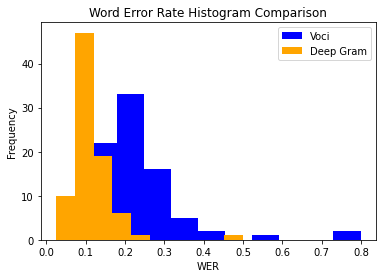

In [26]:
counts, bins = np.histogram(voci_werlist[np.where(voci_werlist<1)])
plt.hist(bins[:-1], bins, weights=counts,color='blue',label='Voci')


counts, bins = np.histogram(dg_werlist[np.where(dg_werlist<1)])
plt.hist(bins[:-1], bins, weights=counts,color='orange',label='Deepgram')
plt.legend()
plt.xlabel('WER')
plt.ylabel('Frequency')
plt.title('Word Error Rate Histogram Comparison')
plt.show()

### Individual Histogram to be use for separate session between deepgram and voci

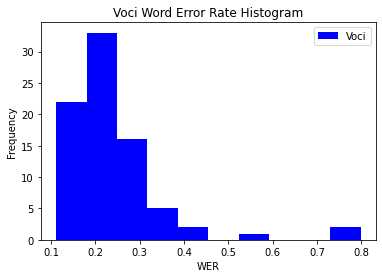

In [27]:
counts, bins = np.histogram(voci_werlist[np.where(voci_werlist<1)])
plt.hist(bins[:-1], bins, weights=counts,color='blue',label='Voci')

plt.legend()
plt.xlabel('WER')
plt.ylabel('Frequency')
plt.title('Voci Word Error Rate Histogram')
plt.show()

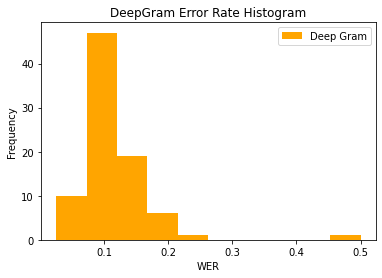

In [28]:
counts, bins = np.histogram(dg_werlist[np.where(dg_werlist<1)])
plt.hist(bins[:-1], bins, weights=counts,color='orange',label='Deepgram')

plt.legend()
plt.xlabel('WER')
plt.ylabel('Frequency')
plt.title('Deepgram Error Rate Histogram')
plt.show()

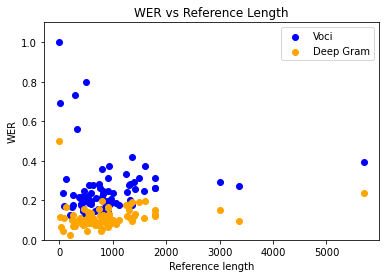

In [29]:
plt.scatter(voci_wer.wer_vs_length.keys(), voci_wer.wer_vs_length.values(),color='blue',label='Voci')
plt.scatter(dg_wer.wer_vs_length.keys(), dg_wer.wer_vs_length.values(),color='Orange',label='Deepgram')
plt.legend()
plt.xlabel('Reference length')
plt.ylabel('WER')
plt.title('WER vs Reference Length')
plt.ylim(0, 1.1)
plt.show()

### Comparison of word Insertion and Deletion

Text(0.5, 1.0, 'Word Insertion Comparison (n>30)')

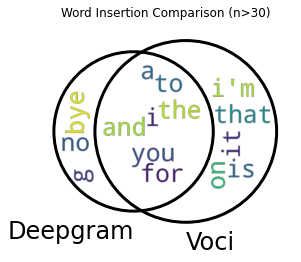

In [30]:
deepgram_insertion = pd.DataFrame(dg_wer.insertion_table.items(), columns=['word', 'insertions']).sort_values('insertions', ascending=False).query('insertions > 30')['word'].to_numpy()
voci_insertion =pd.DataFrame(voci_wer.insertion_table.items(), columns=['word', 'insertions']).sort_values('insertions', ascending=False).query('insertions > 30')['word'].to_numpy()

f, ax = plt.subplots()

v = venn2_wordcloud([set(deepgram_insertion),set(voci_insertion)],set_labels=['Deepgram', 'Voci'],wordcloud_kwargs=dict(max_font_size=100, min_font_size=0),ax=ax)
ax.set_title('Word Insertion Comparison (n>30)')

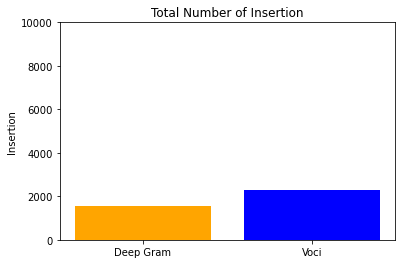

In [36]:
insertion=[pd.DataFrame(dg_wer.insertion_table.items(), columns=['word', 'insertions']).sort_values('insertions', ascending=False)['insertions'].sum(),
         pd.DataFrame(voci_wer.insertion_table.items(), columns=['word', 'insertions']).sort_values('insertions', ascending=False)['insertions'].sum()]
plt.bar([1,],insertion[0],align='center',color='Orange')
plt.bar([2,],insertion[1],align='center',color='Blue')
objects = ('Deepgram', 'Voci')
plt.xticks([1,2], objects)
plt.ylim([0,10000])
plt.ylabel('Insertion')
plt.title('Total Number of Insertion')

plt.show()

         

Text(0.5, 1.0, 'Word Deletion Comparison (n>30)')

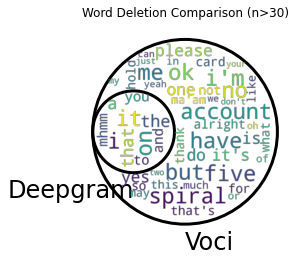

In [37]:
deepgram_deletion = pd.DataFrame(dg_wer.deletion_table.items(), columns=['word', 'deletions']).sort_values('deletions', ascending=False).query('deletions > 30')['word'].to_numpy()
voci_deletion =pd.DataFrame(voci_wer.deletion_table.items(), columns=['word', 'deletions']).sort_values('deletions', ascending=False).query('deletions > 30')['word'].to_numpy()

f, ax = plt.subplots()

v = venn2_wordcloud([set(deepgram_deletion),set(voci_deletion)],set_labels=['Deepgram', 'Voci'],wordcloud_kwargs=dict(max_font_size=100, min_font_size=0),ax=ax)
ax.set_title('Word Deletion Comparison (n>30)')

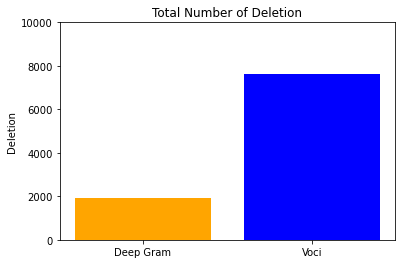

In [39]:
deletion=[pd.DataFrame(dg_wer.deletion_table.items(), columns=['word', 'deletions']).sort_values('deletions', ascending=False)['deletions'].sum(),
         pd.DataFrame(voci_wer.deletion_table.items(), columns=['word', 'deletions']).sort_values('deletions', ascending=False)['deletions'].sum()]
plt.bar([1,],deletion[0],align='center',color='Orange')
plt.bar([2,],deletion[1],align='center',color='Blue')
objects = ('Deepgram', 'Voci')
plt.xticks([1,2], objects)
plt.ylabel('Deletion')
plt.ylim([0,10000])
plt.title('Total Number of Deletion')

plt.show()

         

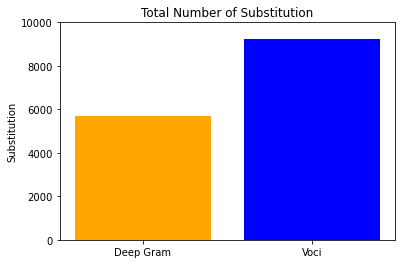

In [40]:
substitution=[pd.DataFrame(dg_wer.substitution_table.items(), columns=['word', 'substitutions']).sort_values('substitutions', ascending=False)['substitutions'].sum(),
         pd.DataFrame(voci_wer.substitution_table.items(), columns=['word', 'substitutions']).sort_values('substitutions', ascending=False)['substitutions'].sum()]
plt.bar([1,],substitution[0],align='center',color='Orange')
plt.bar([2,],substitution[1],align='center',color='Blue')
objects = ('Deepgram', 'Voci')
plt.xticks([1,2], objects)
plt.ylabel('Substitution')
plt.title('Total Number of Substitution')
plt.ylim([0,10000])
plt.show()

         

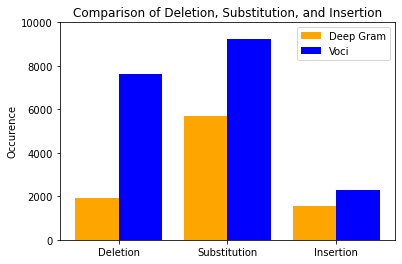

In [42]:
category = ["Deletion","Substitution","Insertion"]
x_axis = np.arange(len(category))
dg_scores = [deletion[0], substitution[0], insertion[0]]
voci_scores = [deletion[1], substitution[1], insertion[1]]

plt.bar(x_axis -0.2, dg_scores, width=0.4, label ="Deepgram",color="orange")
plt.bar(x_axis +0.2, voci_scores, width=0.4, label = "Voci",color="blue")
plt.legend()
plt.xticks(x_axis, category)
plt.ylim([0,deletion[1]])

plt.ylabel('Occurence')
plt.title('Comparison of Deletion, Substitution, and Insertion')
plt.ylim([0,10000])
plt.show()